In [2]:
import cPickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from time import time, sleep
from IPython import display
os.chdir(u'/Users/zbutler/research/fire_prediction')
from data import data
from geometry.grid_conversion import ak_bb, fairbanks_lat_lon, get_latlon_xy_fxns
from prediction.fire_clustering import cluster_over_time_with_merging, FIRE_SEASON
from util.daymonth import day2monthday
%matplotlib inline

In [3]:
# Load all data
modis = data.load_modis() 
gfs_dict = data.load_gfs_dict()
clust_df = data.load_clust_df()
merge_dict = data.load_merge_dict()
min_year = np.min(modis.year)
max_year = np.max(modis.year)
clust_df.iloc[0:10]

,confidence,day,frp,hour,lat,long,minute,month,year,x,y,dayofyear,cluster
1448868,0.24,1,7.1,22,64.808,-147.609,19,5,2007,1046.361463,1088.688,121,NaN
1600851,0.53,17,13.3,22,60.046,-151.492,33,5,2007,862.434548,560.106,137,0.0
1610427,0.43,19,23.8,23,67.019,-158.293,44,5,2007,566.748464,1334.109,139,1.0
1623204,0.35,21,4.5,20,62.808,-138.762,16,5,2007,1509.981794,866.688,141,2.0
1628928,0.81,21,16.8,22,63.922,-146.422,9,5,2007,1110.487294,990.342,141,3.0
1628929,0.59,21,8.2,22,63.919,-146.442,9,5,2007,1109.535052,990.009,141,3.0
1631442,0.74,22,26.9,20,66.646,-149.651,58,5,2007,943.584150,1292.706,142,4.0
1636860,0.80,23,19.2,6,66.637,-149.673,40,5,2007,942.642644,1291.707,143,4.0
1636861,0.63,23,13.1,6,66.651,-149.660,40,5,2007,943.170580,1293.261,143,4.0
1636862,0.97,23,27.1,6,66.646,-149.684,40,5,2007,942.127898,1292.706,143,4.0


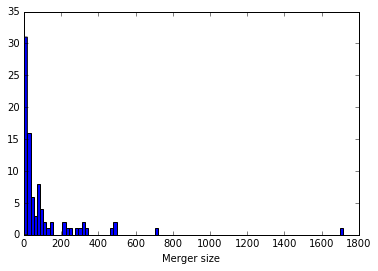

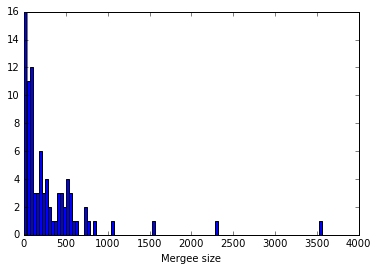

In [4]:
# Plot some merge statistics first
mergee_size = []
merger_size = []
for merger, (mergee, dayofyear) in merge_dict.iteritems():
    mergee_size.append(len(clust_df[(clust_df.cluster==mergee) & (clust_df.dayofyear < dayofyear)]))
    merger_size.append(len(clust_df[(clust_df.cluster==merger) & (clust_df.dayofyear < dayofyear)]))
plt.hist(merger_size, bins=100)
plt.xlabel("Merger size")
plt.savefig("pics/merger_size_10_hist.png")
plt.show()
plt.close()
plt.hist(mergee_size, bins=100)
plt.xlabel("Mergee size")
plt.savefig("pics/mergee_size_10_hist.png")
plt.show()

In [17]:
# Find a couple merges that might be interesting to plot
for merger, (mergee, dayofyear) in merge_dict.iteritems():
    mergee_size = len(clust_df[(clust_df.cluster==mergee) & (clust_df.dayofyear < dayofyear)])
    if mergee_size > 1000:
        print "mergee %d (size %d, year %d)" % (mergee, mergee_size, clust_df[(clust_df.cluster==mergee)].year.unique()[0]),
        print "merger %d (size %d)" % (merger, len(clust_df[(clust_df.cluster==merger) & (clust_df.dayofyear < dayofyear)]))
        print "lat lon: " + str((np.mean(clust_df[(clust_df.cluster==merger)].lat), np.mean(clust_df[(clust_df.cluster==merger)].long)))


mergee 238 (size 3565, year 2009) merger 197 (size 101)
lat lon: (64.35505940594055, -150.39864356435643)
mergee 212 (size 1057, year 2009) merger 241 (size 1)
lat lon: (63.584, -138.24)
mergee 955 (size 1537, year 2015) merger 918 (size 497)
lat lon: (65.67682696177057, -152.35497384305833)
mergee 917 (size 2291, year 2015) merger 961 (size 1715)
lat lon: (66.02340816326542, -154.46649970845465)


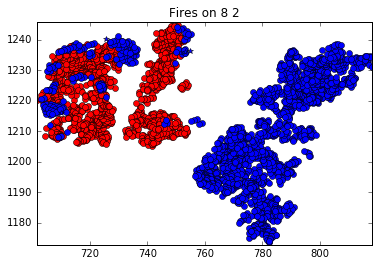

In [13]:
# Let's check out monster merger 917/961
from util.daymonth import monthday2day
mergee = 917
merger = 961
mergee_df = clust_df[clust_df.cluster == mergee]
merger_df = clust_df[clust_df.cluster == merger]
year = mergee_df.year.unique()[0]
min_day = min(np.min(mergee_df.dayofyear), np.min(merger_df.dayofyear))
max_day = np.max(mergee_df.dayofyear)

# Get size in grid
min_x = min(np.min(mergee_df.x), np.min(merger_df.x))
max_x = max(np.max(mergee_df.x), np.max(merger_df.x))
min_y = min(np.min(mergee_df.y), np.min(merger_df.y))
max_y = max(np.max(mergee_df.y), np.max(merger_df.y))
prev_merger_xs = []
prev_mergee_xs = []
prev_merger_ys = []
prev_mergee_ys = []
day = monthday2day(8,1)
for dayofyear in xrange(int(min_day), int(merge_dict[merger][1])+2):
    merger_fires = merger_df[merger_df.dayofyear == dayofyear]
    mergee_fires = mergee_df[mergee_df.dayofyear == dayofyear]
    display.clear_output(wait=True)
#    plt.figure(figsize=(5,10))
    axes = plt.gca()
    axes.set_xlim([min_x,max_x])
    axes.set_ylim([min_y,max_y])
    if len(prev_merger_xs):
        plt.plot(prev_merger_xs, prev_merger_ys, 'ro')
    if len(prev_mergee_xs):
        plt.plot(prev_mergee_xs, prev_mergee_ys, 'bo')

    if len(merger_fires):
        today_xs, today_ys = (np.array(merger_fires.x), np.array(merger_fires.y))
        plt.plot(today_xs, today_ys, 'r*')
        prev_merger_xs += list(today_xs)
        prev_merger_ys += list(today_ys)
    if len(mergee_fires):
        today_xs, today_ys = (np.array(mergee_fires.x), np.array(mergee_fires.y))
        plt.plot(today_xs, today_ys, 'b*')
        prev_mergee_xs += list(today_xs)
        prev_mergee_ys += list(today_ys)
    month, day = day2monthday(dayofyear, (year % 4) == 0)
    plt.title("Fires on %d %d" %(month, day))
    plt.show()
    sleep(1)
    dayofyear += 1